seeds:
 [[840.66133429 325.61859599]
 [898.87009571 905.98460775]
 [310.45732591 424.4829053 ]
 [253.89319402 759.835644  ]
 [822.83033914 750.04532829]
 [705.72679845 950.63761314]
 [550.78384658 597.00453057]
 [  2.56911516 193.09988936]
 [284.7687521  576.45632276]
 [606.31814136 802.08349794]
 [162.89617793 770.34703187]
 [636.02076374 264.25696866]
 [659.99470462 398.73708975]
 [ 62.74457738 912.05018519]
 [247.90716279 861.70012018]
 [926.47557578 164.03634631]
 [892.81759987 175.53045689]
 [136.02587241 481.7533988 ]
 [362.5197753  842.04614715]
 [556.37638337 510.57861308]
 [653.63024219 557.73140494]
 [802.02223124 422.69285814]
 [276.43340034 346.89918646]
 [809.61891086 426.97910804]
 [735.14059729 590.53289646]
 [662.02931341 839.93397775]
 [882.67733028 422.38440054]
 [202.21633792 523.94616617]
 [988.73529674 197.68294362]
 [490.00762005 842.58620406]
 [341.35838637 718.58216154]
 [948.3539561  514.86234644]
 [647.5333847  276.99538346]
 [425.33874834 861.4259543 ]
 [386.

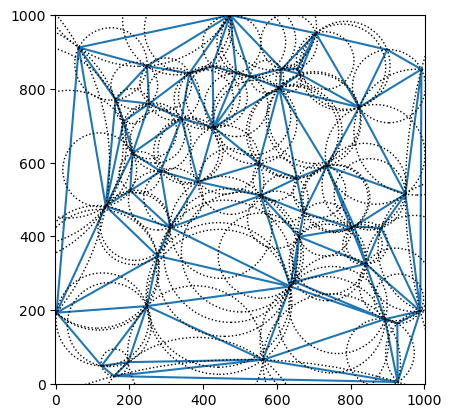

In [2]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.tri
import matplotlib.collections


class Delaunay:
    def __init__(self, center=(0, 0), radius=9999):
        center = np.asarray(center)
        self.coords = [center + radius * np.array((-1, -1)),
                       center + radius * np.array((+1, -1)),
                       center + radius * np.array((+1, +1)),
                       center + radius * np.array((-1, +1))]

        self.triangles = {}
        self.circles = {}

        t1 = (0, 1, 3)
        t2 = (2, 3, 1)
        self.triangles[t1] = [t2, None, None]
        self.triangles[t2] = [t1, None, None]

        for t in self.triangles:
            self.circles[t] = self.circum_center(t)

    def circum_center(self, tri):
        pts = np.asarray([self.coords[v] for v in tri])
        pts2 = np.dot(pts, pts.T)
        a = np.bmat([[2 * pts2, [[1],
                                 [1],
                                 [1]]],
                     [[[1, 1, 1, 0]]]])

        b = np.hstack((np.sum(pts * pts, axis=1), [1]))
        x = np.linalg.solve(a, b)
        bary_coords = x[:-1]
        center = np.dot(bary_coords, pts)

        radius = np.sum(np.square(pts[0] - center))
        return (center, radius)

    def inCircleFast(self, tri, p):
        center, radius = self.circles[tri]
        return np.sum(np.square(center - p)) <= radius

    def addPoint(self, p):
        p = np.asarray(p)
        idx = len(self.coords)
        print("coords[", idx,"] ->",p)
        self.coords.append(p)

        bad_triangles = []
        for temp in self.triangles:
            if self.inCircleFast(temp, p):
                bad_triangles.append(temp)

        boundary = []
        temp = bad_triangles[0]
        edge = 0
        while True:
            print('-'*10)
            print(f"temp: {temp}")
            tri_op = self.triangles[temp][edge]
            print(f'tri_op: {tri_op}')
            if tri_op not in bad_triangles:
                print("not in bad")
                boundary.append((temp[(edge + 1) % 3], temp[(edge - 1) % 3], tri_op))
                edge = (edge + 1) % 3
                print(f"edge: {edge}")
                print(f"boundary: {boundary}")
                if boundary[0][0] == boundary[-1][1]:
                    break
            else:
                print("in bad")
                edge = (self.triangles[tri_op].index(temp) + 1) % 3
                temp = tri_op
                print(f"edge: {edge}")
                print(f"temp: {temp}")

        print('-' * 10)
        for temp in bad_triangles:
            del self.triangles[temp]
            del self.circles[temp]

        new_triangles = []
        for (e0, e1, tri_op) in boundary:
            temp = (idx, e0, e1)
            self.circles[temp] = self.circum_center(temp)
            self.triangles[temp] = [tri_op, None, None]

            if tri_op:
                for i, neigh in enumerate(self.triangles[tri_op]):
                    if neigh:
                        if e1 in neigh and e0 in neigh:
                            self.triangles[tri_op][i] = temp

            new_triangles.append(temp)

        n = len(new_triangles)
        for i, temp in enumerate(new_triangles):
            self.triangles[temp][1] = new_triangles[(i + 1) % n]
            self.triangles[temp][2] = new_triangles[(i - 1) % n]

    def exportTriangles(self):
        return [(a - 4, b - 4, c - 4)
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]

    def exportCircles(self):
        return [(self.circles[(a, b, c)][0], sqrt(self.circles[(a, b, c)][1]))
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]


def plot_one(num_seeds, square_size, addCircles=False):
    seeds = square_size * np.random.random((num_seeds, 2))
    print("seeds:\n", seeds)
    print("BBox Min:", np.amin(seeds, axis=0),
          "Bbox Max: ", np.amax(seeds, axis=0))

    center = np.mean(seeds, axis=0)
    dt = Delaunay(center, 50 * square_size)

    for s in seeds:
        dt.addPoint(s)

    print(len(dt.exportTriangles()), "Delaunay triangles")

    fig, ax = plt.subplots()
    ax.margins(0.1)
    ax.set_aspect('equal')
    plt.axis([-1, square_size + 1, -1, square_size + 1])

    cx, cy = zip(*seeds)
    dt_tris = dt.exportTriangles()
    ax.triplot(matplotlib.tri.Triangulation(cx, cy, dt_tris))

    if addCircles:
        for c, r in dt.exportCircles():
            ax.add_artist(plt.Circle(c, r, color='k', fill=False, ls='dotted'))

    plt.show()


def step_by_step_plot(num_seeds, square_size, addCircles=False):
    seeds = square_size * np.random.random((num_seeds, 2))
    print("seeds:\n", seeds)
    print("BBox Min:", np.amin(seeds, axis=0),
          "Bbox Max: ", np.amax(seeds, axis=0))

    center = np.mean(seeds, axis=0)

    dt2 = Delaunay(center, 50 * square_size)
    for i, s in enumerate(seeds):
        print("Inserting seed", i, s)
        dt2.addPoint(s)
        if i > 1:
            fig, ax = plt.subplots()
            ax.margins(0.1)
            ax.set_aspect('equal')
            plt.axis([-1, square_size + 1, -1, square_size + 1])
            for i, v in enumerate(seeds):
                plt.annotate(i, xy=v)
            for t in dt2.exportTriangles():
                polygon = [seeds[i] for i in t]
                plt.fill(*zip(*polygon), fill=False, color="b")
                if addCircles:
                    for c, r in dt2.exportCircles():
                        ax.add_artist(plt.Circle(c, r, color='k', fill=False, ls='dotted'))
            plt.show()


if __name__ == '__main__':
    num_seeds = 50
    square_size = 1000

    plot_one(
        num_seeds=num_seeds,
        square_size=square_size,
        addCircles=True
    )

    '''step_by_step_plot(
        num_seeds=num_seeds,
        square_size=square_size,
        addCircles=False
    )'''
    
